In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

import colorcet as cc
from copy import deepcopy
import itertools
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from sklearn import manifold
import sys
import torch
from tqdm.auto import tqdm

plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

sys.path.append('..')
from data_utils import get_data_class, load_session_data, load_window_from_chunks, combine_grid_results

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from dmd import embed_signal_torch
from utils import numpy_torch_conversion

In [4]:
os.system('echo host:\nhostname')
print(f"cuda: {torch.cuda.is_available()}")
print(f"{torch.from_numpy(np.random.randn(4)).to('cuda').cpu().numpy()}")

host:
node084
cuda: True
[-0.89335183 -1.45729684  0.25124421 -0.76033872]


In [5]:
def get_section(t, section_times):
    for section, bounds in section_times.items():
        if t >= bounds[0] and t < bounds[1]:
            return section

def intersection(a, b):
    return [x for x in a if x in b]

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [6]:
# session = 'MrJones-Anesthesia-20160125-"01'
session = 'Mary-Anesthesia-20160912-02'
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
variables = ['electrodeInfo', 'sessionInfo', 'trialInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, session_info, trial_info = session_vars['electrodeInfo'], session_vars['sessionInfo'], session_vars['trialInfo']

In [7]:
dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"
directory = pd.read_pickle(os.path.join(dir_, "directory"))

In [12]:
trial_info.keys()

dict_keys(['Properties', 'badTimingTrials', 'badTrials', 'cpt_puffOff', 'cpt_puffOn', 'cpt_refTime', 'cpt_toneOff', 'cpt_toneOn', 'cpt_trialType', 'drugPhase', 'drugPhaseTime', 'refTime', 'session', 'task', 'trial', 'trialStart'])

# Getting Sample LFPs

In [13]:
session_info['drugStart'], session_info['eyesClose'], trial_info['cpt_toneOn'][0]

(array([1155.19066667, 2955.19066667]), 1480.6452666666667, 87.86223333333334)

In [14]:
wake_lfps = load_window_from_chunks(500, 515, directory)

In [16]:
anesthesia_lfps = load_window_from_chunks(2900, 2915, directory)

In [25]:
ret_data = {'wake_lfps': wake_lfps, 'anesthesia_lfps': anesthesia_lfps, 'area_list': electrode_info['area'], 'dt': dt}
pd.to_pickle(ret_data, os.path.join("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/data", "data_for_sarthak.pkl"))

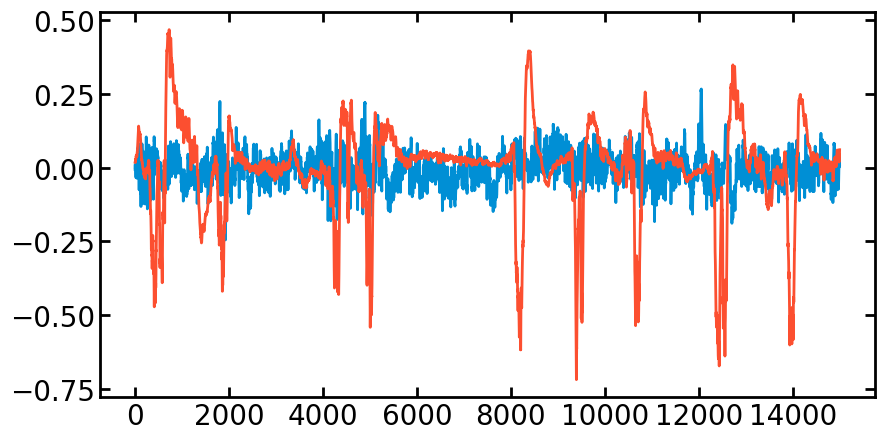

In [19]:
plt.plot(wake_lfps[:, 0])
plt.plot(anesthesia_lfps[:, 0])
plt.show()

# Testing Something

In [12]:
lfps = load_window_from_chunks(24, 30, directory)

In [14]:
delase = DeLASE(lfps, n_delays=4)

In [19]:
lfps.shape

(6000, 231)

In [15]:
delase.DMD.fit()

In [33]:
rank = 4
np.abs(delase.DMD.V[:, :rank].T @ delase.DMD.V[:, :rank] - np.eye(rank)).max()

tensor(6.2585e-07, dtype=torch.float64)

In [6]:
def get_trial_responses(session_list, leadin=1, response_length=2, leadout=1, verbose=False):
    # =================================
    # COUNT TRIALS
    # =================================

    trial_counts = None
    session_dicts = {}
    verbose = True
    for i, session in tqdm(enumerate(session_list), desc='Loading trial info', disable=not verbose, total=len(session_list)):
        # ---------------------------------
        # Load data
        # ---------------------------------
        all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
        data_class = get_data_class(session, all_data_dir)

        os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
        variables = ['electrodeInfo', 'sessionInfo', 'trialInfo']
        session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
        electrode_info, session_info, trial_info = session_vars['electrodeInfo'], session_vars['sessionInfo'], session_vars['trialInfo']

        eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
        eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

        section_times = dict( 
            wake=(trial_info['cpt_refTime'][0], session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugStart'][1]),
            late_anesthesia=(session_info['drugStart'][1], session_info['drugEnd'][1]),
            recovery1=(session_info['drugEnd'][1], eyes_open),
            recovery2=(eyes_open, T*dt)
        )

        if 'MrJones' in session:
            section_times['wake_sac'] = (0, trial_info['cpt_refTime'][0])  

        sections = list(section_times.keys())

        # ---------------------------------
        # Count trials
        # ---------------------------------

        if trial_counts is None:
            trial_counts = {}
            for section in sections:
                trial_counts[section] = {}
                for trial_type in np.unique(trial_info['cpt_trialType']):
                    trial_counts[section][trial_type] = 0

        for _type, _t in zip(trial_info['cpt_trialType'], trial_info['cpt_refTime']):
            section = get_section(_t, section_times)
            if _t - leadin >= section_times[section][0] and _t + response_length + leadout <= section_times[section][1]:
                trial_counts[section][_type] += 1
        
        session_dicts[session] = {
            'electrode_info': electrode_info,
            'session_info': session_info,
            'trial_info': trial_info,
            'eyes_open': eyes_open,
            'eyes_close': eyes_close,
            'section_times': section_times,
        }

    # find channels that are common to all sessions
    all_channel_index = None
    for session in session_dicts.keys():
        electrode_info = session_dicts[session]['electrode_info']
        if all_channel_index is None:
            all_channel_index = [f"{nsp}_{int(channel)}" for nsp, channel in zip(electrode_info['NSP'], electrode_info['channel'])]
            all_areas = electrode_info['area']
        else:
            channel_index = [f"{nsp}_{int(channel)}" for nsp, channel in zip(electrode_info['NSP'], electrode_info['channel'])]
            all_channel_index = intersection(channel_index, all_channel_index)

    N = len(all_channel_index)

    # for each session, compute the channel reindex
    for session in session_dicts.keys():
        electrode_info = session_dicts[session]['electrode_info']
        channel_index = [f"{nsp}_{int(channel)}" for nsp, channel in zip(electrode_info['NSP'], electrode_info['channel'])]
        session_dicts[session]['channel_reindex'] = [channel_index.index(ind) for ind in all_channel_index]

    channel_areas = session_dicts[session]['electrode_info']['area'][session_dicts[session]['channel_reindex']]

    # =================================
    # GET THE TRIAL LFPS
    # =================================

    # set up trial responses empty
    trial_responses = {}
    for section in trial_counts.keys():
        trial_responses[section] = {}
        for trial_type in trial_counts[section].keys():
            # assumes all sessions have same dt
            trial_responses[section][trial_type] = np.zeros((trial_counts[section][trial_type], int((response_length + leadin + leadout)/dt), N))

    iterator = tqdm(total = np.sum([np.sum([trial_counts[section][trial_type] for trial_type in trial_counts[section].keys()]) for section in trial_counts.keys()]), desc="Trials", disable = not verbose)
    for i, session in enumerate(session_list):
        electrode_info = session_dicts[session]['electrode_info']
        session_info = session_dicts[session]['session_info']
        trial_info = session_dicts[session]['trial_info']
        eyes_close = session_dicts[session]['eyes_close']
        eyes_open = session_dicts[session]['eyes_open']
        section_times = session_dicts[session]['section_times']
        sections = list(section_times.keys())
        channel_reindex = session_dicts[session]['channel_reindex']

        dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"
        directory = pd.read_pickle(os.path.join(dir_, "directory"))

        # ---------------------------------
        # Get trial responses
        # ---------------------------------
        trial_index = {}
        for section in trial_counts.keys():
            trial_index[section] = {}
            for trial_type in trial_counts[section].keys():
                trial_index[section][trial_type] = 0

        for _type, _t in zip(trial_info['cpt_trialType'], trial_info['cpt_refTime']):
            section = get_section(_t, section_times)
            if _t - leadin >= section_times[section][0] and _t + response_length + leadout <= section_times[section][1]:
                response = load_window_from_chunks(_t - leadin, _t + response_length + leadout, directory)[:, channel_reindex]
                response = np.expand_dims(response, 0)

                trial_responses[section][_type][trial_index[section][_type], :, :] = response
                trial_index[section][_type] += 1
                iterator.update(1)
    
    iterator.close()
    
    return trial_responses, channel_areas

In [7]:
section_colors = {
    'late_anesthesia': 'plum',
    'anesthesia': 'darkorchid',
    'wake': 'limegreen',
}

In [8]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/dimensionality_reduction/trial_responses'
leadin = 2
response_length = 2
leadout = 3

# Load Trial Responses

In [13]:
all_sessions = [f[:-4] for f in os.listdir("/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone") if f.endswith(".mat")]


names = ['Mary', 'MrJones']

all_trial_responses = {}
for name in names:
    print(f"====================\n{name}\n====================")
    session_list = [sesh for sesh in all_sessions if name in sesh]
    trial_responses, channel_areas = get_trial_responses(session_list, leadin=leadin, response_length=response_length, leadout=leadout, verbose=True)

    all_trial_responses[name] = dict(
        trial_responses=trial_responses,
        channel_areas=channel_areas,
    )

Mary


Loading trial info:   0%|          | 0/10 [00:00<?, ?it/s]

Trials:   0%|          | 0/11818 [00:00<?, ?it/s]

MrJones


Loading trial info:   0%|          | 0/11 [00:00<?, ?it/s]

Trials:   0%|          | 0/11580 [00:00<?, ?it/s]

# Electrode Level Responses

In [14]:
# start_time = 1
# end_time = leadin + 2

# sections_to_plot = ['wake', 'anesthesia']
# # trials_to_plot = ['toneOnly', 'tonePuff']

# fig, axs = plt.subplots(len(trial_responses[sections_to_plot[0]]), 2, figsize=(20, 12), sharex=True, sharey=True)

# # cmap = plt.cm.get_cmap('RdYlBu_r')
# # color_list = cmap(np.linspace(0, 1, int(response_length/dt) + int((leadin + leadout)/dt))[:delay_embed.shape[1]])

# for i, name in enumerate(all_trial_responses.keys()):
#     trial_responses = all_trial_responses[name]['trial_responses']
#     channel_areas = all_trial_responses[name]['channel_areas']
#     for j, trial_type in enumerate(trial_responses[sections_to_plot[0]].keys()):
#             ax = axs[j][i]
#             for section in sections_to_plot:
#                 time_vals = np.arange(trial_responses[section][trial_type].shape[1])*dt
#                 time_inds = np.where((time_vals >= start_time) & (time_vals <= end_time))[0]
#                 time_vals = time_vals[time_inds] - leadin

#                 responses = trial_responses[section][trial_type][:, :, np.where(channel_areas == 'CPB')[0]]
#                 # responses = trial_responses[section][trial_type]
#                 responses = responses[:, time_inds, :]  
                
#                 mean_vals = responses.mean(axis=0).mean(axis=1)
#                 ax.scatter(time_vals, mean_vals, color=section_colors[section], s=1)
#                 # stderr = np.sqrt(((responses - np.expand_dims(np.expand_dims(mean_vals, 0),-1))**2).mean(axis=(0, 2)))/np.sqrt(responses.shape[0]*responses.shape[2])
#                 # ax.fill_between(time_vals, mean_vals - stderr, mean_vals + stderr, alpha=0.5, color=section_colors[section])
#                 ax.set_title(f"{name} - {trial_type}")
#         # if trial_type == 'puffOnly':
#         #     ax.axvline(leadin - gap*dt, color='k', linestyle='--', alpha=0.5)

# # sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('RdYlBu_r'), norm=plt.Normalize(vmin=0, vmax=1))

# plt.tight_layout()
# # cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
# # cbar = fig.colorbar(sm, ticks=np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1), [leadin - gap*dt, leadin + 0.5 - gap*dt, leadin + 1 - gap*dt]])/int(n_timepts*dt), cax=cbar_ax)
# # cbar.ax.set_yticklabels(np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1) + gap*dt, ['input onset', 'tone offset', 'puff (cued)']]))
# # cbar.set_label('Time in Trajectory (s)')

# plt.show()

In [15]:
dt = 0.001

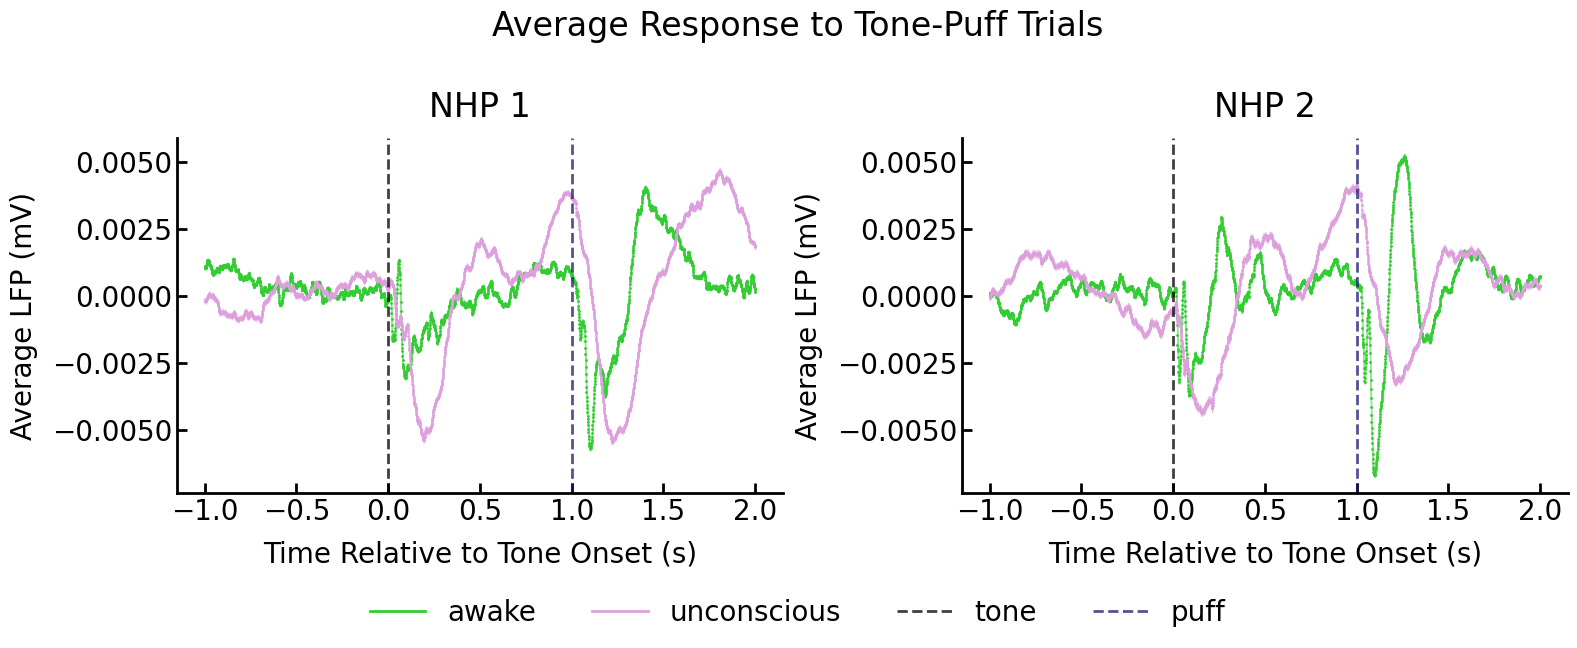

In [16]:
start_time = 1
end_time = leadin + 2

sections_to_plot = ['wake', 'late_anesthesia']
# trials_to_plot = ['toneOnly', 'tonePuff']
# trials_to_plot = ['tonePuff']
trials_to_plot = ['tonePuff']

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# cmap = plt.cm.get_cmap('RdYlBu_r')
# color_list = cmap(np.linspace(0, 1, int(response_length/dt) + int((leadin + leadout)/dt))[:delay_embed.shape[1]])

for i, name in enumerate(all_trial_responses.keys()):
        trial_responses = all_trial_responses[name]['trial_responses']
        channel_areas = all_trial_responses[name]['channel_areas']
        ax = axs[i]

        for section in sections_to_plot:
                time_vals = np.arange(trial_responses[section][trials_to_plot[0]].shape[1])*dt
                time_inds = np.where((time_vals >= start_time) & (time_vals <= end_time))[0]
                time_vals = time_vals[time_inds] - leadin

                # responses = trial_responses[section][trial_type]
                responses = np.vstack([trial_responses[section][trial_type] for trial_type in trials_to_plot])
                # responses = responses[:, :, np.where(channel_areas == 'CPB')[0]]
                responses = responses[:, time_inds, :]  

                mean_vals = responses.mean(axis=0).mean(axis=1)
                ax.scatter(time_vals, mean_vals, color=section_colors[section], s=1)
                stderr = np.sqrt(((responses - np.expand_dims(np.expand_dims(mean_vals, 0),-1))**2).mean(axis=(0, 2)))/np.sqrt(responses.shape[0]*responses.shape[2])
                ax.fill_between(time_vals, mean_vals - stderr, mean_vals + stderr, alpha=0.5, color=section_colors[section])
        ax.set_title(f"NHP {i + 1}")
        ax.set_xlabel('Time Relative to Tone Onset (s)')
        ax.set_ylabel('Average LFP (mV)')

        ax.axvline(0, color='k', linestyle='--', lw=2, alpha=0.75, label='tone')
        ax.axvline(1, color='midnightblue', linestyle='--', lw=2, alpha=0.75, label='puff')

        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
                # if trial_type == 'puffOnly':
                #     ax.axvline(leadin - gap*dt, color='k', linestyle='--', alpha=0.5)

# sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('RdYlBu_r'), norm=plt.Normalize(vmin=0, vmax=1))

plt.suptitle('Average Response to Tone-Puff Trials')
plt.tight_layout()

lns = []
lns += plt.plot([], color='limegreen', label='awake')
lns += plt.plot([], color='plum', label='unconscious')
lns += plt.plot([], color='k', linestyle='--', lw=2, alpha=0.75, label='tone')
lns += plt.plot([], color='midnightblue', linestyle='--', lw=2, alpha=0.75, label='puff')
fig.legend(lns, [ln.get_label() for ln in lns], loc='center', ncol=4, bbox_to_anchor=(0.5, -0.025))

# cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
# cbar = fig.colorbar(sm, ticks=np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1), [leadin - gap*dt, leadin + 0.5 - gap*dt, leadin + 1 - gap*dt]])/int(n_timepts*dt), cax=cbar_ax)
# cbar.ax.set_yticklabels(np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1) + gap*dt, ['input onset', 'tone offset', 'puff (cued)']]))
# cbar.set_label('Time in Trajectory (s)')

plt.show()

In [17]:
drop_keys = []
for name in all_trial_responses.keys():
    for section in all_trial_responses[name]['trial_responses'].keys():
        for trial_type in all_trial_responses[name]['trial_responses'][section].keys():
           if all_trial_responses[name]['trial_responses'][section][trial_type].shape[0] == 0:
               print(f"{name}, {section}, {trial_type} is empty")
               drop_keys.append((name, section, trial_type))

for name, section, trial_type in drop_keys:
    del all_trial_responses[name]['trial_responses'][section][trial_type]

drop_sections = []
for name in all_trial_responses.keys():
    for section in all_trial_responses[name]['trial_responses'].keys():
        if not all_trial_responses[name]['trial_responses'][section]:
            print(f"deleting {name}, {section}")
            drop_sections.append((name, section))

for name, section in drop_sections:
    del all_trial_responses[name]['trial_responses'][section]

MrJones, wake_sac, puffOnly is empty
MrJones, wake_sac, toneOnly is empty
MrJones, wake_sac, tonePuff is empty
deleting MrJones, wake_sac


# Delay Embed and Do PCA

In [9]:
# for n_delays, delay_interval in [(1, 1), (2, 1), (2, 10), (2, 20), (5, 20), (10, 20)]:
n_delays = 32
delay_interval = 20
for n_delays, delay_interval in [(n_delays, delay_interval)]:
    print("-"*60)
    print(f"n_delays: {n_delays}, delay_interval: {delay_interval}")
    save_path = os.path.join(save_dir, f"all_delay_embedding_{leadin}_{response_length}_{leadout}_{n_delays}_{delay_interval}.pkl")

    if not os.path.exists(save_path):

        batch_size = 25
        num_total_trials = np.sum([np.sum([np.sum([trial_responses[section][trial_type].shape[0] for trial_type in trial_responses[section].keys()]) for section in trial_responses.keys()]) for trial_responses in [all_trial_responses[name]['trial_responses'] for name in all_trial_responses.keys()]])
        iterator = tqdm(total=num_total_trials, desc="Delay Embedding")

        all_delay_embeddings_avg = {}
        for name in all_trial_responses.keys():
            trial_responses = all_trial_responses[name]['trial_responses']

            delay_embeddings_avg = {}
            
            for section in trial_responses.keys():
                delay_embeddings_avg[section] = {}
                for trial_type in trial_responses[section].keys():
                    delay_embeddings_avg[section][trial_type] = None
                    num_batches = int(np.ceil(trial_responses[section][trial_type].shape[0]/batch_size))
                    # for trial_num in range(trial_responses[section][trial_type].shape[0]):
                    for batch_num in range(num_batches):
                        batch_start = batch_num*batch_size
                        batch_end = np.min([(batch_num + 1)*batch_size, trial_responses[section][trial_type].shape[0]])
                        with torch.no_grad():
                            x = torch.from_numpy(trial_responses[section][trial_type][batch_start:batch_end]).to('cuda')
                            delay_embed = embed_signal_torch(x, n_delays, delay_interval)
                            delay_embed = delay_embed.sum(axis=0).cpu().numpy()
                            if delay_embeddings_avg[section][trial_type] is None:
                                delay_embeddings_avg[section][trial_type] = delay_embed
                            else:
                                delay_embeddings_avg[section][trial_type] += delay_embed

                        iterator.update(batch_end - batch_start)
                
                    delay_embeddings_avg[section][trial_type] /= trial_responses[section][trial_type].shape[0]
            
            all_delay_embeddings_avg[name] = delay_embeddings_avg

        iterator.close()

        pd.to_pickle(all_delay_embeddings_avg, save_path)
    else:
        print("loading delay embeddings from file")
        all_delay_embeddings_avg = pd.read_pickle(save_path)

    save_path = os.path.join(save_dir, f"all_pca_responses_{leadin}_{response_length}_{leadout}_{n_delays}_{delay_interval}.pkl")
    if not os.path.exists(save_path):
        all_pca_its = np.sum([len(delay_embeddings_avg.keys())*len(trial_responses[list(delay_embeddings_avg.keys())[0]].keys()) for delay_embeddings_avg in all_delay_embeddings_avg.values()])
        iterator = tqdm(total=all_pca_its, desc="PCA")

        all_pca_responses = {}
        for name in all_trial_responses.keys():
            trial_responses = all_trial_responses[name]['trial_responses']
            delay_embeddings_avg = all_delay_embeddings_avg[name]
            pca_responses = {}
            
            for section in delay_embeddings_avg.keys():
                for trial_type in delay_embeddings_avg[section].keys():
                    if section not in pca_responses.keys():
                        pca_responses[section] = {}

                    pca_responses[section][trial_type] = {}
                    delay_embed = delay_embeddings_avg[section][trial_type]
                    pca = PCA(n_components=3)
                    pca_responses[section][trial_type]['embed'] = pca.fit_transform(delay_embed)
                    pca_responses[section][trial_type]['explained_variance_ratio'] = pca.explained_variance_ratio_
                    # print(f"{section} {trial_type}: {pca.explained_variance_ratio_}")

                    iterator.update()

            all_pca_responses[name] = pca_responses
        iterator.close()
        pd.to_pickle(all_pca_responses, save_path)
    else:
        print("loading pca responses from file")
        all_pca_responses = pd.read_pickle(save_path)
        print("loaded!")

------------------------------------------------------------
n_delays: 32, delay_interval: 20
loading delay embeddings from file
loading pca responses from file
loaded!


# Plot

In [10]:
dt = 0.001

In [11]:
names = list(all_pca_responses.keys())
sections = list(all_pca_responses[names[0]].keys())
trial_types = list(all_pca_responses[names[0]][sections[0]].keys())

In [12]:
n_timepts = all_pca_responses[names[0]][sections[0]][trial_types[0]]['embed'].shape[0]

In [21]:
# color_list = {
#     'toneOnly': np.vstack([
#         plt.cm.get_cmap('copper')(np.linspace(0, 1, int(leadin/dt))),
#         plt.cm.get_cmap('spring')(np.linspace(0, 1, int(0.5/dt))),
#         plt.cm.get_cmap('Wistia')(np.linspace(0, 1, int((response_length - 0.5)/dt))),
#         plt.cm.get_cmap('RdYlBu_r')(np.linspace(0, 1, n_timepts - int((leadin + response_length)/dt))),
#     ]),
#     'puffOnly': plt.cm.get_cmap('RdYlBu_r')(np.linspace(0, 1, n_timepts)),
#     'tonePuff': plt.cm.get_cmap('RdYlBu_r')(np.linspace(0, 1, n_timepts))
# }

cmap_name = 'cet_CET_C7'

color_list = {
    'toneOnly': colormaps.get_cmap(cmap_name)(np.linspace(0, 1, n_timepts)),
    'puffOnly': colormaps.get_cmap(cmap_name)(np.linspace(0, 1, n_timepts)),
    'tonePuff': colormaps.get_cmap(cmap_name)(np.linspace(0, 1, n_timepts))
}

# MMP: Multi Monkey Plots

In [13]:
n_timepts

6380

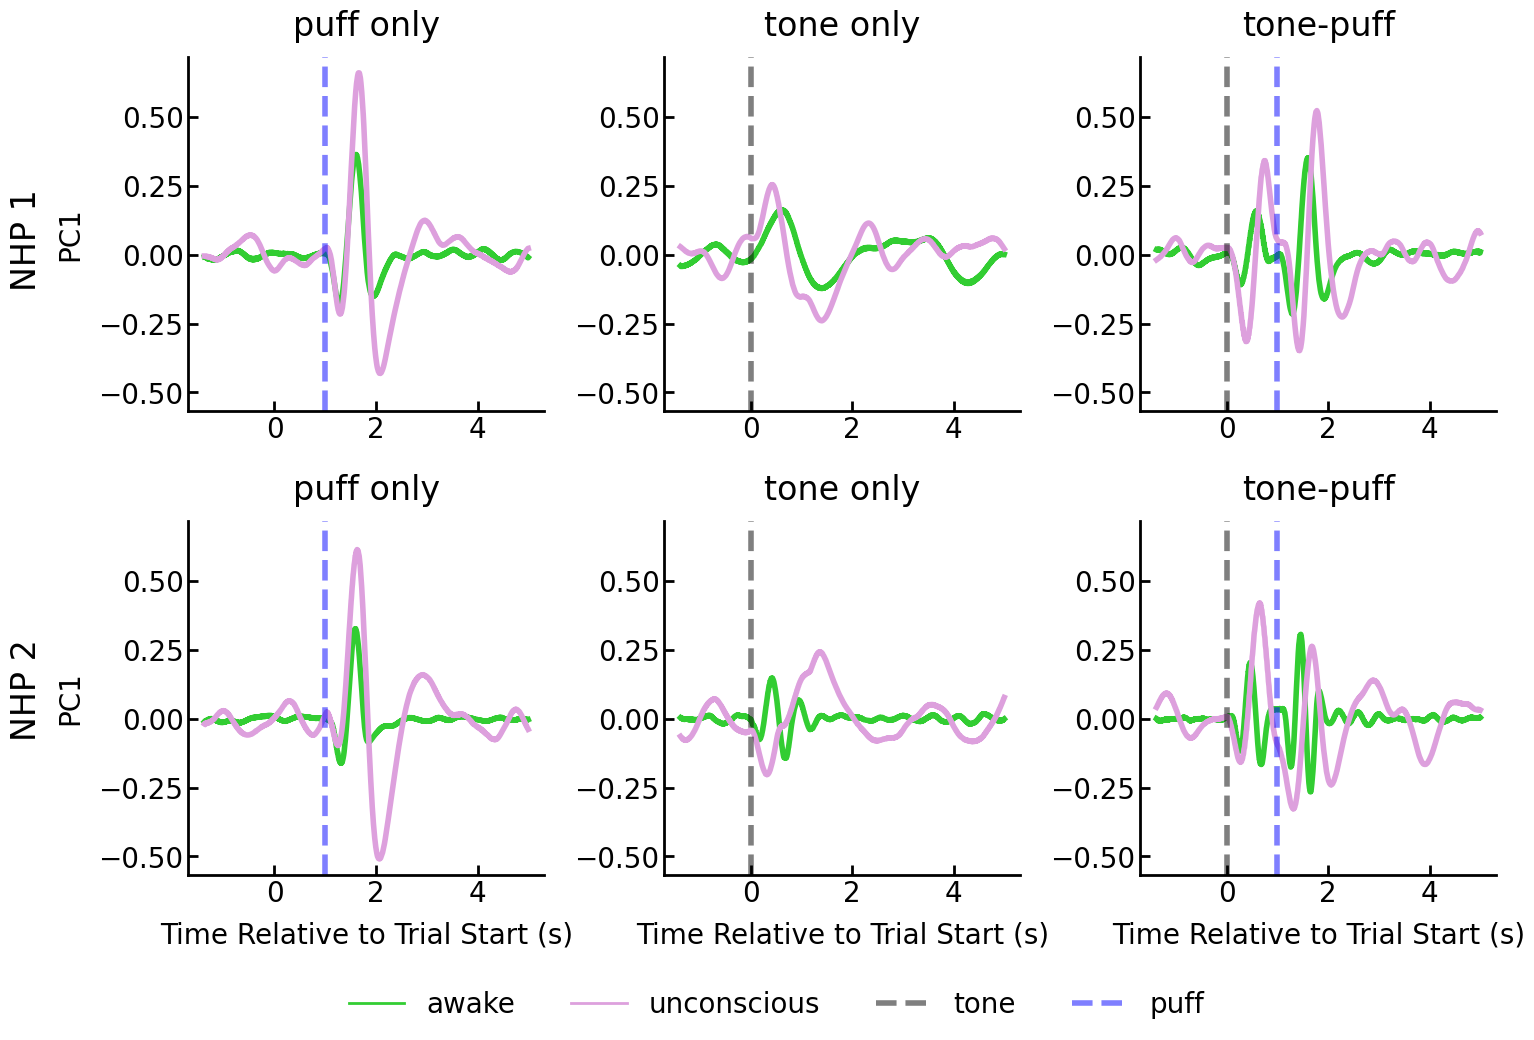

In [25]:
# gap = (int((response_length + leadin + leadout)/dt) - n_timepts)/2
gap = (int((response_length + leadin + leadout)/dt) - n_timepts)
# gap = 0

# subplot_title_fontsize = 16
# xlabel_fontsize = 16
# ylabel_fontsize = 16
# xticklab

sections_to_plot = ['wake', 'late_anesthesia']

trial_type_labels = {
    'puffOnly': 'puff only',
    'toneOnly': 'tone only',
    'tonePuff': 'tone-puff'
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# cmap = plt.cm.get_cmap('RdYlBu_r')
# color_list = cmap(np.linspace(0, 1, int(response_length/dt) + int((leadin + leadout)/dt))[:delay_embed.shape[1]])
for i, name in enumerate(names):
    pca_responses = all_pca_responses[name]
    for j, trial_type in enumerate(pca_responses[list(pca_responses.keys())[0]].keys()):
        ax = axs[i][j]
        for section in sections_to_plot:
            time_vals = (np.arange(pca_responses[section][trial_type]['embed'].shape[0]) + gap)*dt - leadin
            ax.plot(time_vals, pca_responses[section][trial_type]['embed'][:, 0], label='section', c=section_colors[section], lw=4)
            # ax.scatter(time_vals, pca_responses[section][trial_type]['embed'][:, 1])
            ax.set_title(f"{trial_type_labels[trial_type]}")

        if trial_type == 'puffOnly' or trial_type == 'tonePuff':
            ax.axvline(1, color='blue', linestyle='--', alpha=0.5, lw=4)
        if trial_type == 'toneOnly' or trial_type == 'tonePuff':
            ax.axvline(0, color='k', linestyle='--', alpha=0.5, lw=4)
        
        if i == 1:
            ax.set_xlabel('Time Relative to Trial Start (s)')
        if j == 0:
            ax.set_ylabel('PC1')

        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

lns = []
lns += plt.plot([], color='limegreen', label='awake')
lns += plt.plot([], color='plum', label='unconscious')
lns += plt.plot([], color='k', linestyle='--', alpha=0.5, label='tone', lw=4)
lns += plt.plot([], color='blue', linestyle='--', alpha=0.5, label='puff', lw=4)
fig.legend(lns, [ln.get_label() for ln in lns], loc='center', ncol=4, bbox_to_anchor=(0.5, -0.025))

fig.text(0, 0.74, 'NHP 1', ha='center', va='center', fontsize=24, rotation='vertical')
fig.text(0, 0.29, 'NHP 2', ha='center', va='center', fontsize=24, rotation='vertical')


plt.tight_layout()
# cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
# cbar = fig.colorbar(sm, ticks=np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1), [leadin - gap*dt, leadin + 0.5 - gap*dt, leadin + 1 - gap*dt]])/int(n_timepts*dt), cax=cbar_ax)
# cbar.ax.set_yticklabels(np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1) + gap*dt, ['input onset', 'tone offset', 'puff (cued)']]))
# cbar.set_label('Time in Trajectory (s)')

plt.show()

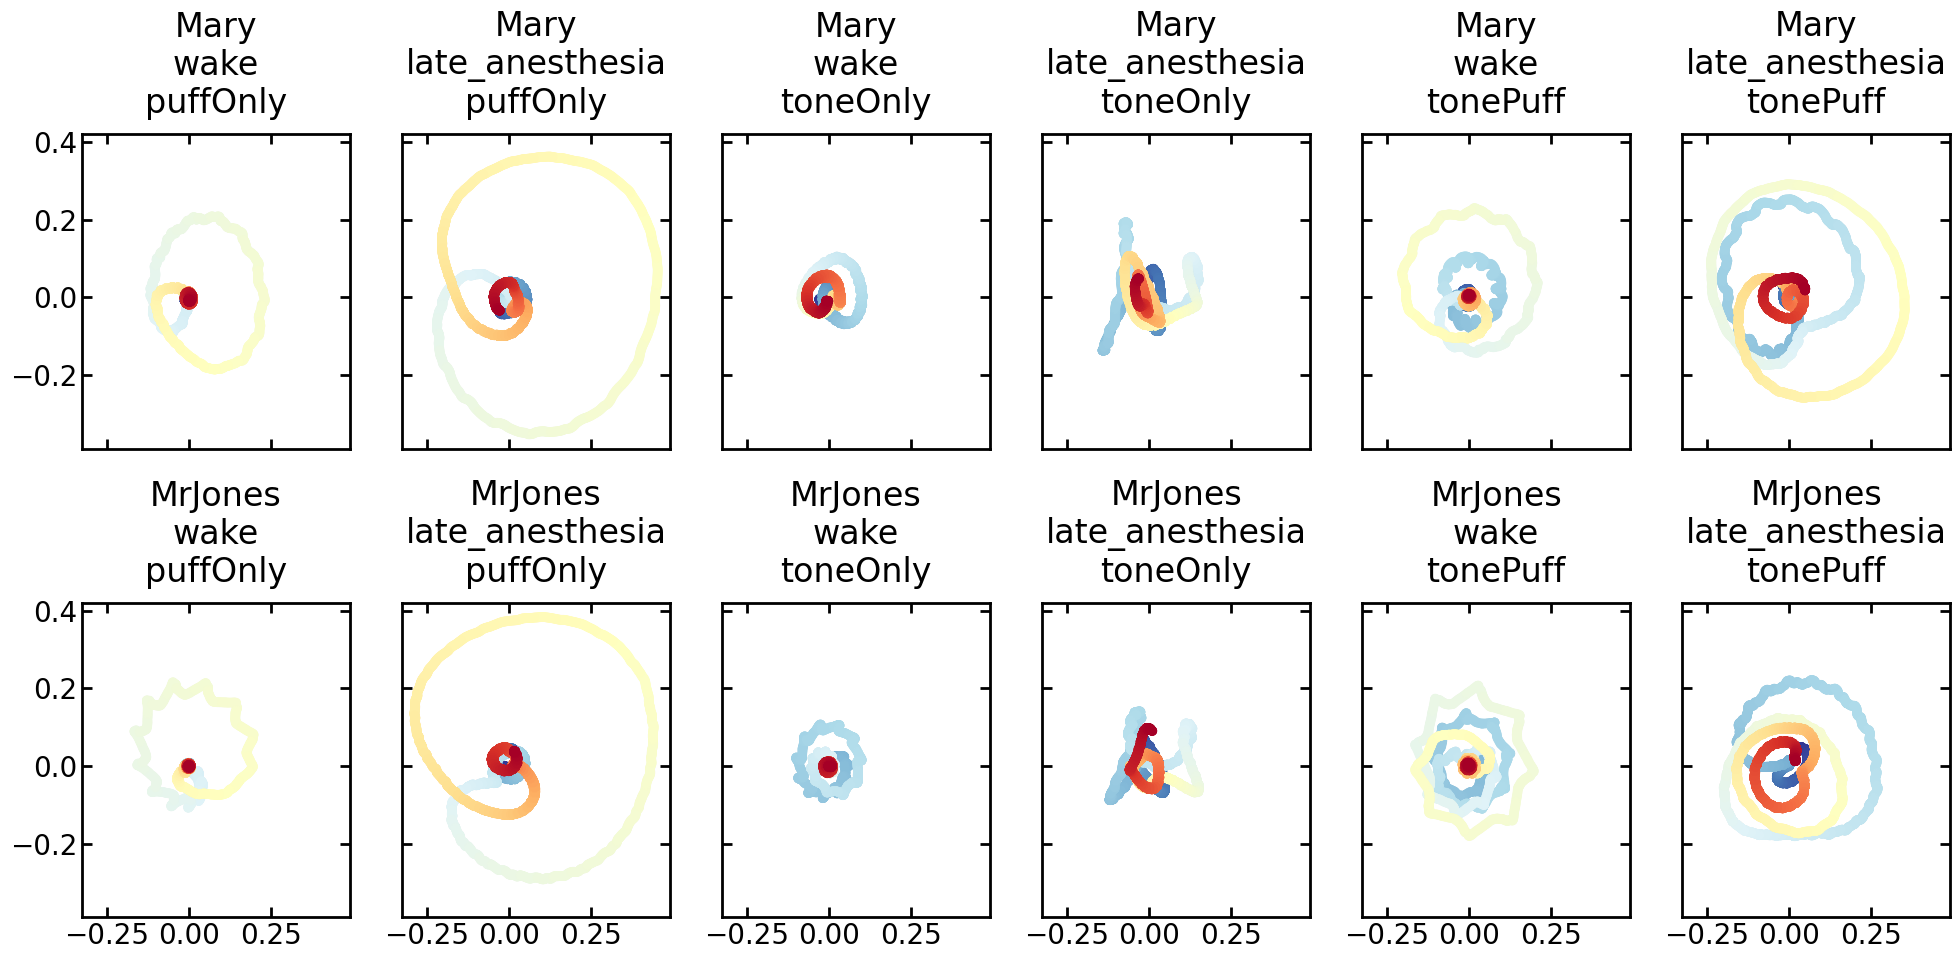

In [86]:
# gap = (int((response_length + leadin + leadout)/dt) - n_timepts)/2
gap = (int((response_length + leadin + leadout)/dt) - n_timepts)
# gap = 0

sections_to_plot = ['wake', 'late_anesthesia']

fig, axs = plt.subplots(2, len(pca_responses[list(pca_responses.keys())[0]])*len(sections_to_plot), figsize=(20, 10), sharex=True, sharey=True)

# cmap = plt.cm.get_cmap('RdYlBu_r')
# color_list = cmap(np.linspace(0, 1, int(response_length/dt) + int((leadin + leadout)/dt))[:delay_embed.shape[1]])
for i, name in enumerate(names):
    pca_responses = all_pca_responses[name]
    for k, section in enumerate(sections_to_plot):
        for j, trial_type in enumerate(pca_responses[section].keys()):
            ax = axs[i][j*len(sections_to_plot) + k]
            time_vals = (np.arange(pca_responses[section][trial_type]['embed'].shape[0]) + gap)*dt - leadin
            ax.scatter(pca_responses[section][trial_type]['embed'][:, 0], pca_responses[section][trial_type]['embed'][:, 1], c=color_list[trial_type])
            # ax.scatter(time_vals, pca_responses[section][trial_type]['embed'][:, 1])
            ax.set_title(f"{name}\n{section}\n{trial_type}")

sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('RdYlBu_r'), norm=plt.Normalize(vmin=0, vmax=1))

plt.tight_layout()
# cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
# cbar = fig.colorbar(sm, ticks=np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1), [leadin - gap*dt, leadin + 0.5 - gap*dt, leadin + 1 - gap*dt]])/int(n_timepts*dt), cax=cbar_ax)
# cbar.ax.set_yticklabels(np.hstack([np.arange(0, int(n_timepts*dt) + 1, 1) + gap*dt, ['input onset', 'tone offset', 'puff (cued)']]))
# cbar.set_label('Time in Trajectory (s)')

plt.show()

# Tone Puff Only

In [16]:
trial_type = 'tonePuff'

In [17]:
img_save_dir = '/om/user/eisenaj/ChaoticConsciousness/images'

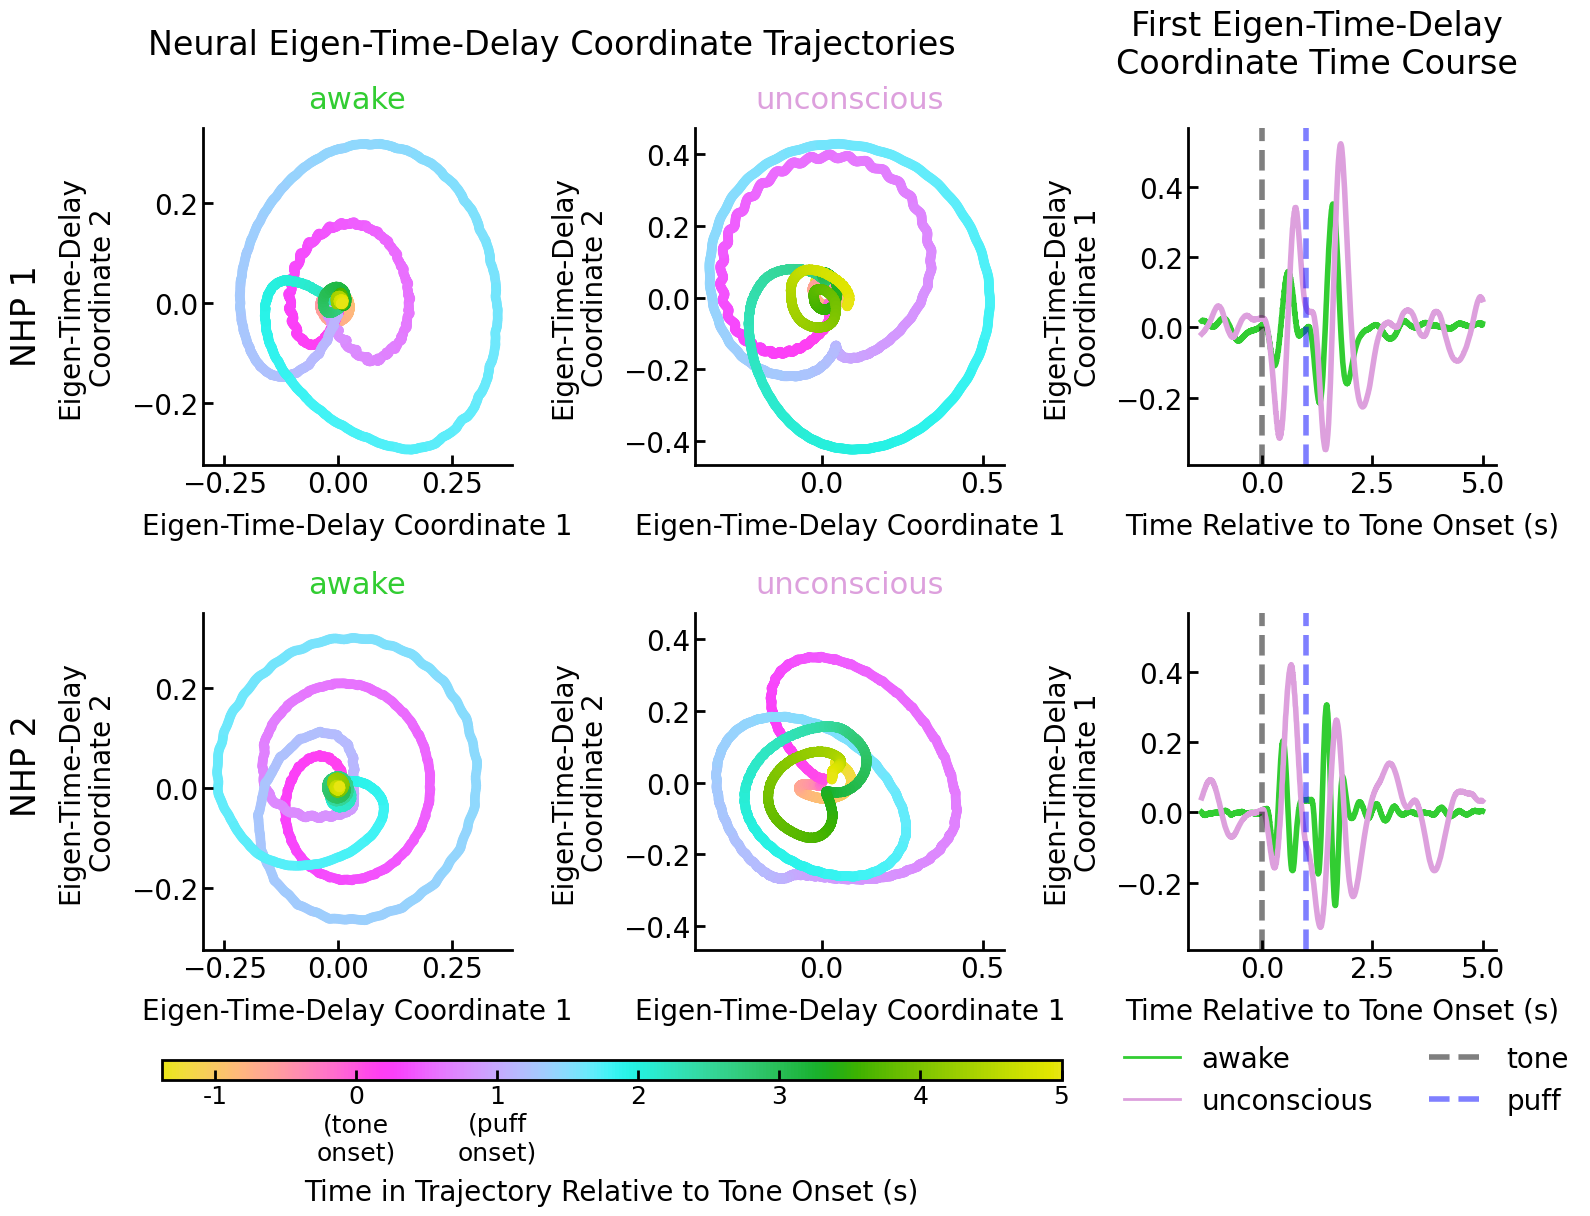

In [25]:
# gap = (int((response_length + leadin + leadout)/dt) - n_timepts)/2
gap = (int((response_length + leadin + leadout)/dt) - n_timepts)
# gap = 0

# subplot_title_fontsize = 16
# xlabel_fontsize = 16
# ylabel_fontsize = 16
# xticklab

sections_to_plot = ['wake', 'late_anesthesia']

trial_type_labels = {
    'puffOnly': 'puff only',
    'toneOnly': 'tone only',
    'tonePuff': 'tone-puff'
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex='col', sharey='col')

# cmap = plt.cm.get_cmap('RdYlBu_r')
# color_list = cmap(np.linspace(0, 1, int(response_length/dt) + int((leadin + leadout)/dt))[:delay_embed.shape[1]])
for i, name in enumerate(names):
    pca_responses = all_pca_responses[name]
    for j in range(3):
        ax = axs[i][j]
        if j == 2:
            trial_type = 'tonePuff'
            for section in sections_to_plot:
                time_vals = (np.arange(pca_responses[section][trial_type]['embed'].shape[0]) + gap)*dt - leadin
                ax.plot(time_vals, pca_responses[section][trial_type]['embed'][:, 0], label='section', c=section_colors[section], lw=4)
                # ax.scatter(time_vals, pca_responses[section][trial_type]['embed'][:, 1])
           
                

            if trial_type == 'puffOnly' or trial_type == 'tonePuff':
                ax.axvline(1, color='blue', linestyle='--', alpha=0.5, lw=4)
            if trial_type == 'toneOnly' or trial_type == 'tonePuff':
                ax.axvline(0, color='k', linestyle='--', alpha=0.5, lw=4)
            # if i == 0:
                # ax.set_title(f"First PC Timecourse", fontsize=24)
            
            # {trial_type_labels[trial_type]}

            ax.set_xlabel('Time Relative to Tone Onset (s)')
            ax.set_ylabel('Eigen-Time-Delay\nCoordinate 1')
        
        if j < 2:
            section = sections_to_plot[j]
            time_vals = (np.arange(pca_responses[section]['tonePuff']['embed'].shape[0]) + gap)*dt - leadin
            ax.scatter(pca_responses[section]['tonePuff']['embed'][:, 0], pca_responses[section][trial_type]['embed'][:, 1], c=color_list[trial_type])

            ax.set_xlabel('Eigen-Time-Delay Coordinate 1')
            ax.set_ylabel('Eigen-Time-Delay\nCoordinate 2')

            if j == 0:
                ax.set_title("awake", c='limegreen', fontsize=22)
            if j == 1:
                ax.set_title("unconscious", c='plum', fontsize=22)
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

lns = []
lns += plt.plot([], color='limegreen', label='awake')
lns += plt.plot([], color='plum', label='unconscious')
lns += plt.plot([], color='k', linestyle='--', alpha=0.5, label='tone', lw=4)
lns += plt.plot([], color='blue', linestyle='--', alpha=0.5, label='puff', lw=4)
# fig.legend(lns, [ln.get_label() for ln in lns], loc='center', ncol=2, bbox_to_anchor=(0.22, -0.025))
fig.legend(lns, [ln.get_label() for ln in lns], loc='center', ncol=2, bbox_to_anchor=(0.88, -0.025))

fig.text(0, 0.74, 'NHP 1', ha='center', va='center', fontsize=24, rotation='vertical')
fig.text(0, 0.29, 'NHP 2', ha='center', va='center', fontsize=24, rotation='vertical')

# fig.text(0.23, 1.01, 'First PC Timecourse', ha='center', va='center', fontsize=24)
# fig.text(0.68, 1.01, 'PCA State Space Trajectories', ha='center', va='center', fontsize=24)

fig.text(0.86, 1.01, 'First Eigen-Time-Delay\nCoordinate Time Course', ha='center', va='center', fontsize=24)
fig.text(0.35, 1.01, 'Neural Eigen-Time-Delay Coordinate Trajectories', ha='center', va='center', fontsize=24)


plt.tight_layout()

cbar_tick_labels = np.arange(10)
cbar_tick_labels = cbar_tick_labels[cbar_tick_labels <= (leadin + response_length + leadout)]
cbar_tick_labels = cbar_tick_labels[cbar_tick_labels >= gap*dt]
cbar_ticks = cbar_tick_labels/dt - gap
cbar_tick_labels -= leadin
start_ind = np.where(cbar_tick_labels == 0)[0][0]
cbar_tick_labels = list(cbar_tick_labels)
# cbar_tick_labels[]
cbar_tick_labels[start_ind] = f"{cbar_tick_labels[start_ind]:d}\n(tone\nonset)"
cbar_tick_labels[start_ind + 1] = f"{cbar_tick_labels[start_ind + 1]:d}\n(puff\nonset)"


sm = plt.cm.ScalarMappable(cmap=colormaps.get_cmap(cmap_name), norm=plt.Normalize(vmin=0, vmax=1))
cbar_ax = fig.add_axes([0.09, -0.025, 0.6, 0.02])
cbar = fig.colorbar(sm, orientation='horizontal', cax=cbar_ax)
cbar.set_ticks(cbar_ticks/n_timepts)
cbar.set_ticklabels(cbar_tick_labels, fontsize=18)
cbar.set_label('Time in Trajectory Relative to Tone Onset (s)')
plt.savefig(os.path.join(img_save_dir, 'main', 'neural.pdf'), transparent=True, bbox_inches='tight')
plt.show()